In [ ]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.identity import InteractiveBrowserCredential
from azure.ml import MLClient

from azure.ml._constants import AssetTypes
from azure.ml.entities import JobInput

from azure.ml.entities import ImageObjectDetectionSearchSpace, Choice, Uniform, BanditPolicy, JobInput

from azure.ml import automl
# from azure.ml.automl import image_classification

from pprint import pprint

In [ ]:
#Enter details of your AML workspace

# CDLTLL-GPU
# subscription_id = '381b38e9-9840-4719-a5a0-61d9585e1e91' #'<SUBSCRIPTION_ID>'
# resource_group = 'cesardl-automl-eastus2euap-resgrp' # '<RESOURCE_GROUP>'
# workspace = 'cesardl-dist-training-eastus-ws' # '<AML_WORKSPACE_NAME>'

# SAGAR
# subscription_id = "381b38e9-9840-4719-a5a0-61d9585e1e91" #'<SUBSCRIPTION_ID>'
# resource_group = "sasum_centraluseuap_rg" # '<RESOURCE_GROUP>'
# workspace = "sasum-centraluseuap-ws" # '<AML_WORKSPACE_NAME>'

# CDLTLL
# subscription_id = '102a16c3-37d3-48a8-9237-4c9b1e8e80e0' #'<SUBSCRIPTION_ID>'
# resource_group = 'automlpmdemo' # '<RESOURCE_GROUP>'
# workspace = 'cesardl-automl-centraluseuap-ws' # '<AML_WORKSPACE_NAME>'

# JUAMARTI
subscription_id = "381b38e9-9840-4719-a5a0-61d9585e1e91"
resource_group = "juamarti"
workspace = "centraluseuap_phmantri"

In [ ]:
#get a handle to the workspace
credential = InteractiveBrowserCredential() # DefaultAzureCredential()
#credential = DefaultAzureCredential()
ml_client = MLClient(credential, subscription_id, resource_group, workspace)

In [ ]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjectsMask.zip"
data_file = "./odFridgeObjectsMask.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall()
    print("done")
# delete zip file
os.remove(data_file)

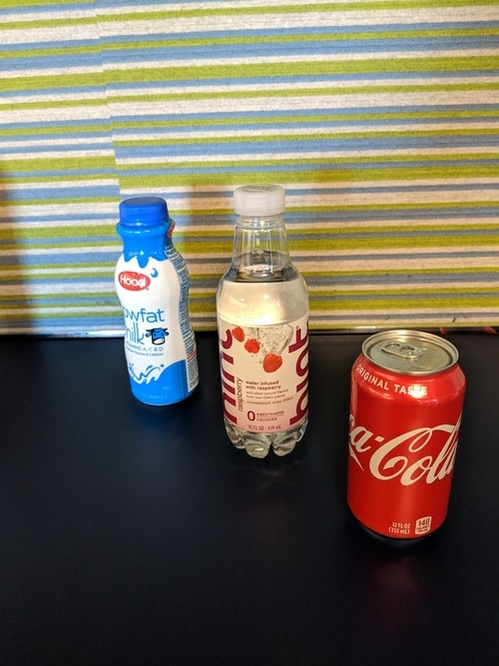

In [1]:
from IPython.display import Image

sample_image = "./odFridgeObjectsMask/images/31.jpg"
Image(filename=sample_image)

### Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

Reference to URI FOLDER data asset example for further details: https://github.com/Azure/azureml-examples/blob/samuel100/data-samples/sdk/assets/data/data.ipynb

In [ ]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ml.entities import Data
from azure.ml._constants import AssetTypes

my_data = Data(
    path="./odFridgeObjectsMask",
    type=AssetTypes.URI_FOLDER,
    description="Fridge-items images instance segmentation",
    name="fridge-items-images-instance-segmentation",
    version='1'
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)


In [ ]:
# Test access to the registered data asset URI-FOLDER if not uploading files.

uri_folder_data_asset = ml_client.data.get(name="fridge-items-images-instance-segmentation", version="1")

print(uri_folder_data_asset)

In [ ]:
# The jsonl_converter below relies on scikit-image and simplification.
# If you don't have them installed, install them before converting data by runing this cell.
%pip install "scikit-image==0.17.2" "simplification==0.5.1"

In [ ]:
from jsonl_converter import convert_mask_in_VOC_to_jsonl

data_path = "./odFridgeObjectsMask/"
convert_mask_in_VOC_to_jsonl(data_path, uri_folder_data_asset.path)

In [ ]:
training_mltable_path = "./training-mltable-folder/"
validation_mltable_path = "./validation-mltable-folder/"

# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = JobInput(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = JobInput(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = JobInput(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = JobInput(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")    

In [ ]:
# Create the AutoML job with the related factory-function.

image_instance_segmentation_job = automl.image_instance_segmentation(
                                        compute = "gpu-cluster",
                                        # name="dpv2-image-classification-job-02",
                                        experiment_name = "dpv2-image-instance-segmentation-experiment",
                                        training_data = my_training_data_input,
                                        validation_data = my_validation_data_input,
                                        target_column_name = "label",
                                        primary_metric = "MeanAveragePrecision",
                                        tags={"owner": "cesardl"},
                        
                                        # These are temporal properties needed in Private Preview
                                        properties={
                                            "_automl_internal_enable_mltable_quick_profile": True,
                                            "_automl_internal_label": "latest"
                                            # "_automl_internal_scenario": "Vision-Candidate",
                                        }
                                    )
    
# Note, since Image classification sweeping is based on a Sweep/HyperDrive run, max_trials=1
# DEFAULTS:
image_instance_segmentation_job.set_limits(max_trials=1, max_concurrent_trials=1)

image_instance_segmentation_job.extend_search_space([
    ImageObjectDetectionSearchSpace(
        model_name=Choice(["maskrcnn_resnet50_fpn"]),
        learning_rate=Uniform(0.0001, 0.001),
        # warmup_cosine_lr_warmup_epochs=Choice([0, 3]),
        optimizer=Choice(["sgd", "adam", "adamw"]),
        min_size=Choice([600, 800]),  
    ),
])

image_instance_segmentation_job.set_sweep(max_trials=10, max_concurrent_trials=2, sampling_algorithm="Random",
                             early_termination=BanditPolicy(
                                 evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
                             ))

## 2.2 Run the CommandJob
Using the `MLClient` created earlier, we will now run this CommandJob in the workspace.

In [ ]:
# Submit the AutoML job (CDLTLL: Is it ml_client.create_or_update(regression_job))
returned_job = ml_client.jobs.create_or_update(image_instance_segmentation_job)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
# Get a URL for the status of the job
print("Open the following link to observe the AutoML training job/run:")

returned_job.services["Studio"].endpoint

# Next Steps
You can see further examples of other AutoML tasks such as Regression, Image-Object-Detection, NLP-Text-Classification, Time-Series-Forcasting, etc.